# Set up

In [2]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/MyDrive'

Mounted at /content/drive


Link to the original dataset: https://github.com/ardamavi/Sign-Language-Digits-Dataset

In [19]:
!pip install split-folders --quiet

In [3]:
!unzip -qq 'drive/MyDrive/Sign-Language-Digits-Dataset.zip'
!unzip -qq 'drive/MyDrive/Sign-Language-Digits-Examples.zip'
!unzip -qq 'drive/MyDrive/Sign-Language-Digits-Test-Images.zip'

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
from torch.nn import Module, Sequential, Linear, Dropout, Conv2d, MaxPool2d, BatchNorm2d, Flatten
from torch.nn import ReLU, Softmax, CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
classes = [
    'eight',
    'five',
    'four',
    'nine',
    'one',
    'seven',
    'six',
    'three',
    'two',
    'zero'
]

# Dataset split

In [69]:
import splitfolders
input_folder = 'Sign-Language-Digits-Dataset'
output = 'Sign-Language-Digits-Dataset-Split-2'
train_ratio = 0.75
# val_ratio = 0.075
test_ratio = 0.25
splitfolders.ratio(
    input_folder,
    output = output,
    seed = 42,
    # ratio = (train_ratio, val_ratio, test_ratio))
    ratio = (train_ratio, test_ratio))

Copying files: 2062 files [00:00, 7856.45 files/s]


# Images augmentation

In [42]:
from PIL import Image

img_path = 'Sign-Language-Digits-Dataset/eight/IMG_1126.JPG'
img = Image.open(img_path)
img_np = np.array(img)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.ToTensor()
])
img_tr = transform(img)
mean, std = img_tr.mean([1, 2]), img_tr.std([1, 2])
print(f'Mean of the image: {mean}')
print(f'Std of the image: {std}')

Mean of the image: tensor([0.6640])
Std of the image: tensor([0.1179])


In [71]:
def get_data(train_dir, test_dir):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.Grayscale(num_output_channels = 1),
        transforms.Resize(size = (100, 100)),
        transforms.ToTensor(),
        transforms.Normalize([0.6640], [0.1179])
    ])
    train_set = datasets.ImageFolder(train_dir, transform = transform)
    test_set = datasets.ImageFolder(test_dir, transform = transform)
    train = DataLoader(train_set, batch_size = 32, shuffle = True)
    test = DataLoader(test_set, batch_size = 32, shuffle = True)
    return train, test

def showcase_images(dataset, classes):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    plt.subplots(4, 5, figsize = (8, 5))
    plt.tight_layout()
    for i in range(0, 20):
        plt.subplot(4, 5, i + 1)
        plt.axis('off')
        plt.gca().set_title(f'{classes[labels[i]]}')
        plt.imshow(images[i].permute(1, 2, 0), cmap = 'gray')
    plt.show()

Train set:


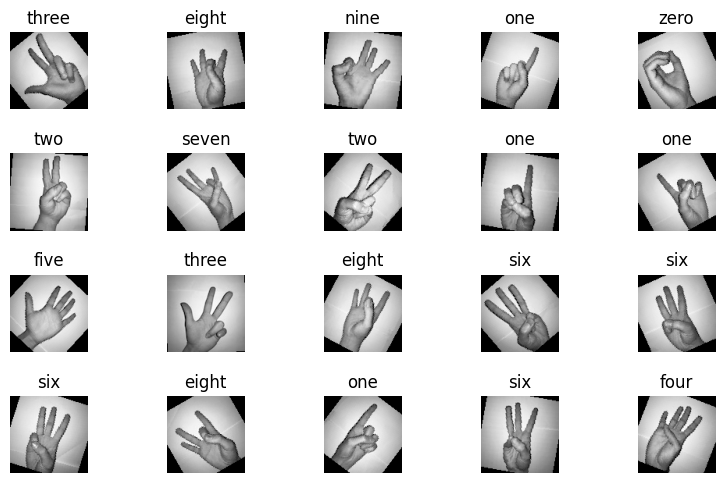

Test set:


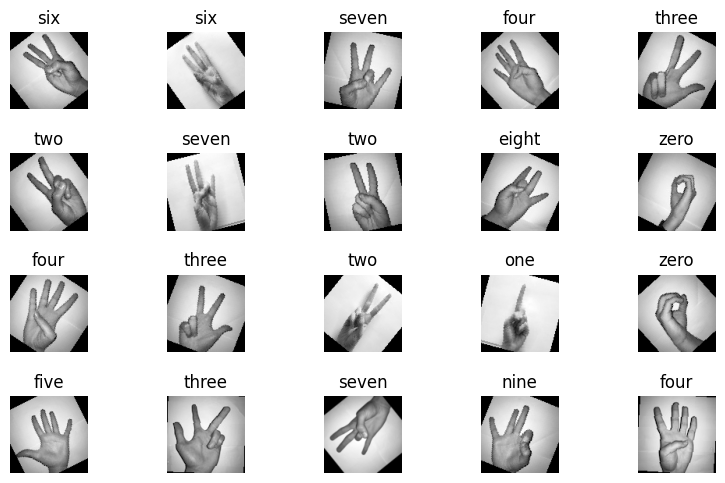

In [72]:
train, test = get_data(
    'Sign-Language-Digits-Dataset-Split-2/train',
    'Sign-Language-Digits-Dataset-Split-2/val')

print('Train set:')
showcase_images(train, classes)
print('Test set:')
showcase_images(test, classes)

# Convolutional neural network for image classification

In [73]:
def show_confusion_matrix(labels_test, labels_predicted, labels = None):
    plt.figure(figsize = (10, 7))
    cm = confusion_matrix(labels_test, labels_predicted)
    if labels != None:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels = labels)
    else:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

def show_training_history(history, metrics, metric_names, figure_size = (7, 6), last_epoch = None):
    if len(metrics) == 1 and len(metric_names) == 1:
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots()
        metric = metrics[0]
        metric_name = metric_names[0]
        ax.plot(history[metric], color = 'b', label = f'Training {metric_name}')
        if f'val_{metric}' in history:
            ax.plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}')
        if last_epoch is not None:
            ax.axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
        legend = ax.legend(loc = 'best', shadow = True)
        plt.show()
    elif len(metrics) > 1 and len(metrics) == len(metric_names):
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots(len(metrics), 1)
        for i in range(len(metrics)):
            metric = metrics[i]
            metric_name = metric_names[i]
            ax[i].plot(history[metric], color = 'b', label = f'Training {metric_name}')
            if f'val_{metric}' in history:
                ax[i].plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}', axes = ax[i])
            if last_epoch is not None:
                ax[i].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
            legend = ax[i].legend(loc = 'best', shadow = True)
        plt.show()
    else:
        raise Exception('Invalid metrics/metric names amount')

## Model

In [74]:
class MyCNN(Module):
    def __init__(self):
        super().__init__()
        self.network = Sequential(
            Conv2d(1, 8, kernel_size = (3, 3)),
            BatchNorm2d(8),
            ReLU(),
            MaxPool2d(2, 2), #output: 8 x 32 x 32
            Conv2d(8, 16, kernel_size = (3, 3)),
            BatchNorm2d(16),
            ReLU(),
            MaxPool2d(2, 2), #output: 16 x 16 x 16
            Conv2d(16, 32, kernel_size = (3, 3)),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(2, 2), #output: 32 x 8 x 8
            Conv2d(32, 64, kernel_size = (3, 3)),
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(2, 2), #output: 64 x 4 x 4
            Flatten(),
            Linear(64 * 4 * 4, 512),
            ReLU(),
            Dropout(0.15),
            Linear(512, 256),
            ReLU(),
            Dropout(0.20),
            Linear(256, 128),
            ReLU(),
            Dropout(0.25),
            Linear(128, 64),
            ReLU(),
            Linear(64, 10),
            Softmax(dim = 1))

    def forward(self, x):
        return self.network(x)

cnn = MyCNN()
cnn.to(device)
cnn

MyCNN(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

## Training

In [75]:
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.001)
loss_function = CrossEntropyLoss()
total_step = len(train)
losses = []
accuracies = []
epochs = 50

for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train):
        cnn.train()
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        loss.backward()
        losses.append(loss.item())
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total
        accuracies.append(accuracy)
        optimizer.step()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Step [10/49], Loss: 2.303, Accuracy: 0.156
Epoch [1/50], Step [20/49], Loss: 2.303, Accuracy: 0.094
Epoch [1/50], Step [30/49], Loss: 2.292, Accuracy: 0.094
Epoch [1/50], Step [40/49], Loss: 2.251, Accuracy: 0.156
Epoch [2/50], Step [10/49], Loss: 2.200, Accuracy: 0.156
Epoch [2/50], Step [20/49], Loss: 2.111, Accuracy: 0.344
Epoch [2/50], Step [30/49], Loss: 2.152, Accuracy: 0.312
Epoch [2/50], Step [40/49], Loss: 1.967, Accuracy: 0.531
Epoch [3/50], Step [10/49], Loss: 2.130, Accuracy: 0.281
Epoch [3/50], Step [20/49], Loss: 1.981, Accuracy: 0.406
Epoch [3/50], Step [30/49], Loss: 1.954, Accuracy: 0.500
Epoch [3/50], Step [40/49], Loss: 2.036, Accuracy: 0.438
Epoch [4/50], Step [10/49], Loss: 1.911, Accuracy: 0.594
Epoch [4/50], Step [20/49], Loss: 2.100, Accuracy: 0.344
Epoch [4/50], Step [30/49], Loss: 2.106, Accuracy: 0.344
Epoch [4/50], Step [40/49], Loss: 2.081, Accuracy: 0.375
Epoch [5/50], Step [10/49], Loss: 1.883, Accuracy: 0.594
Epoch [5/50], Step [20/49], Los

## Evaluation

In [87]:
cnn.eval()
correct = 0
total = 0
images_count = 0
y_true = []
y_pred = []
for i, (images, labels) in enumerate(test):
    images, labels = images.to(device), labels.to(device)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    y_true.extend(labels.cpu().tolist())
    y_pred.extend(predicted.cpu().tolist())
    images_count += len(images)

print(f'Test accuracy of the model on the {images_count} test images: {(correct / total) * 100:.2f}%')

Test accuracy of the model on the 519 test images: 86.51%


In [94]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(classes)
print(encoder.inverse_transform([0]))
print(encoder.classes_)

['eight']
['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'zero']


<Figure size 700x600 with 0 Axes>

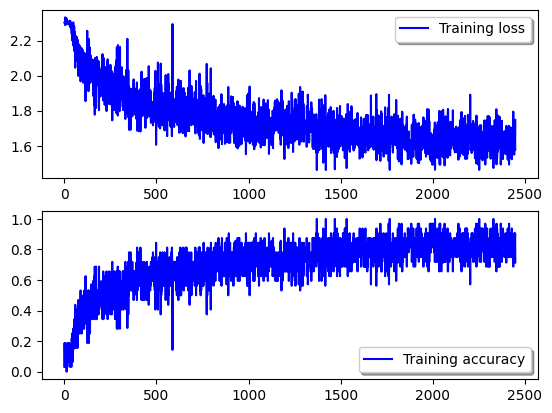

              precision    recall  f1-score   support

       eight       0.62      0.85      0.72        52
        five       0.98      1.00      0.99        52
        four       1.00      0.81      0.89        52
        nine       0.84      0.84      0.84        51
         one       0.91      0.94      0.92        52
       seven       0.84      0.60      0.70        52
         six       0.94      0.88      0.91        52
       three       0.78      0.96      0.86        52
         two       0.95      0.77      0.85        52
        zero       0.93      1.00      0.96        52

    accuracy                           0.87       519
   macro avg       0.88      0.87      0.87       519
weighted avg       0.88      0.87      0.87       519



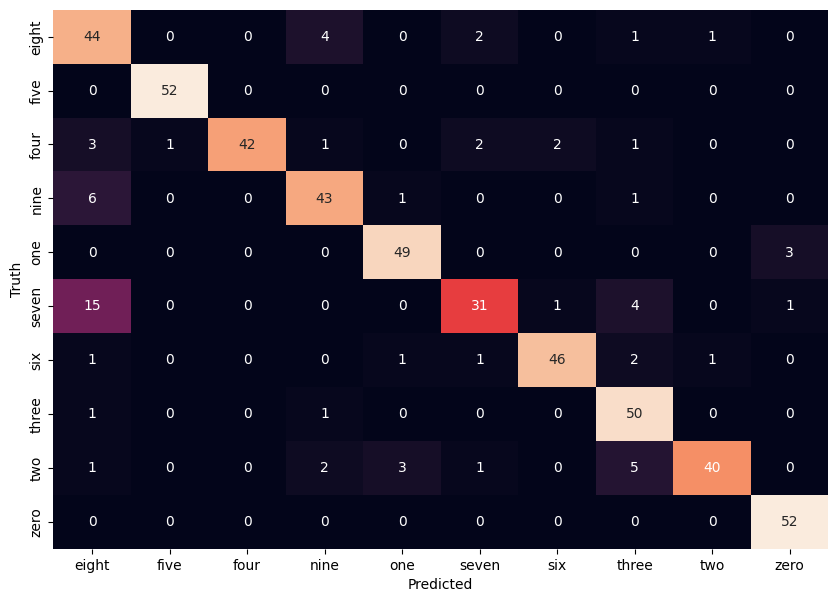

In [95]:
history = {}
history['accuracy'] = accuracies
history['loss'] = losses

show_training_history(history, metrics = ['loss', 'accuracy'], metric_names = ['loss', 'accuracy'])
print(classification_report(
    encoder.inverse_transform(y_true),
    encoder.inverse_transform(y_pred)))
show_confusion_matrix(y_true, y_pred, list(encoder.classes_))

# Model testing

In [133]:
from PIL import Image
import os

def test_model(model, label_encoder, image_path, image_width, image_height, num_channels):
    test_image = Image.open(image_path)
    test_image_resized = test_image.resize((image_width, image_height))
    monochrome_image = np.asarray(test_image_resized.convert('L'))
    monochrome_test_image_reshaped = np.reshape(monochrome_image, (1, image_width, image_height, num_channels))
    monochrome_test_image_reshaped = np.moveaxis(monochrome_test_image_reshaped, 3, 1)
    X = monochrome_test_image_reshaped
    image_normalized = (X - np.mean(X))/np.std(X)
    inference = model(torch.tensor(image_normalized, dtype = torch.float32).to(device))
    inference = inference.detach().cpu().numpy()
    predicted_value = np.argmax(inference, axis = -1)
    predicted_label = label_encoder.inverse_transform(predicted_value)[0]
    probability = inference[0][predicted_value][0]
    return test_image_resized, predicted_value, predicted_label, inference, probability

def test_model_on_image(model, label_encoder, image_path, image_width, image_height, num_channels):
    image, predicted_value, predicted_label, _, probability = test_model(
        model,
        label_encoder,
        image_path,
        image_width,
        image_height,
        num_channels)
    plt.figure(figsize = (2, 2))
    plt.axis('off')
    plt.gca().set_title(f'{predicted_label} ({probability * 100:.2f}%)')
    plt.imshow(image)
    plt.show()

def test_model_on_dataset(model, label_encoder, dataset_path, labels, image_width, image_height, num_channels):
    y_true = []
    y_pred = []
    for label in labels:
        folder = dataset_path + '/' + label
        for folder_file in os.listdir(folder):
            image_path = folder + '/' + folder_file
            try:
                image, predicted_value, predicted_label, _, probability = test_model(
                    model,
                    label_encoder,
                    image_path,
                    image_width,
                    image_height,
                    num_channels)
                y_true.append(label_encoder.transform([label]))
                y_pred.append(predicted_value)
                plt.figure(figsize = (2, 2))
                plt.axis('off')
                label_name = predicted_label if (predicted_label == label) else f'{predicted_label} [X] - {label}'
                plt.gca().set_title(f'{label_name} ({probability * 100:.2f}%)')
                plt.imshow(image)
                plt.show()
            except Exception as ex:
                print(f'Prediction failed on image "{image_path}": {ex}')
    return y_true, y_pred

Eight


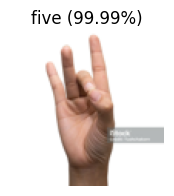

Five


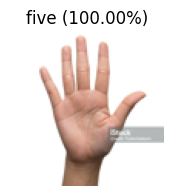

Two


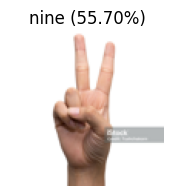

Four


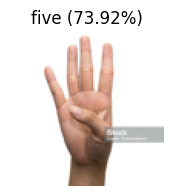

Nine


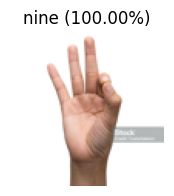

Three


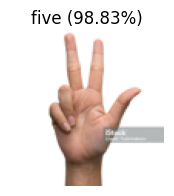

Eight


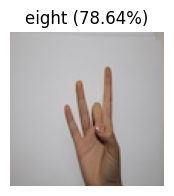

Seven


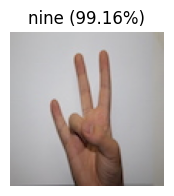

One


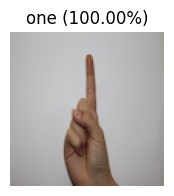

Zero


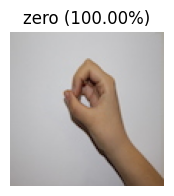

In [134]:
print('Eight')
test_model_on_image(cnn, encoder, 'eight.png', 100, 100, 1)
print('Five')
test_model_on_image(cnn, encoder, 'five.png', 100, 100, 1)
print('Two')
test_model_on_image(cnn, encoder, 'two.png', 100, 100, 1)
print('Four')
test_model_on_image(cnn, encoder, 'four.png', 100, 100, 1)
print('Nine')
test_model_on_image(cnn, encoder, 'nine.png', 100, 100, 1)
print('Three')
test_model_on_image(cnn, encoder, 'three.png', 100, 100, 1)
print('Eight')
test_model_on_image(cnn, encoder, 'Sign-Language-Digits-Dataset-Split-2/train/eight/IMG_1126.JPG', 100, 100, 1)
print('Seven')
test_model_on_image(cnn, encoder, 'Sign-Language-Digits-Dataset-Split-2/train/seven/IMG_1155.JPG', 100, 100, 1)
print('One')
test_model_on_image(cnn, encoder, 'Sign-Language-Digits-Dataset-Split-2/train/one/IMG_1119.JPG', 100, 100, 1)
print('Zero')
test_model_on_image(cnn, encoder, 'Sign-Language-Digits-Dataset-Split-2/train/zero/IMG_1118.JPG', 100, 100, 1)